In [1]:
import os
import sys

# add path to sys
SRC_DIR = os.path.dirname(os.path.abspath('../../src'))
sys.path.append(SRC_DIR)

# import modules
import torch
import glob
from src import parse_args, Trainer
from src.models import *
from src.utils import *

In [2]:
# data path
pc_filename = '/media/shubham/GoldMine/datasets/KITTI/raw/2011_09_26/2011_09_26_drive_0009_sync/velodyne_points/data/0000000100.bin'
img_filename = '/media/shubham/GoldMine/datasets/KITTI/raw/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/0000000100.png'

## Load Model

In [3]:
exp_str = 'vr3d.learning_rate_0.0001.n_xgrids_16.n_ygrids_16.xlim_0.0_70.0.ylim_-25.0_25.0.zlim_-2.5_1.0.max_depth_100.0.vol_size_256x256x16.img_size_512x256.dense_depth_True.concat_latent_vector_True.exp_id_kitti'

# define model
obj_label_len = len(pose_fields) + len(label_map) # 9 for poses, rest for object classes
model = VR3Dense(in_channels=1, n_xgrids=16, n_ygrids=16, obj_label_len=obj_label_len).to('cuda')

# load weights
model = load_pretrained_weights(model, '../../models', exp_str)

# define trainer
trainer = Trainer(dataroot=None, model=model, dataset=None, dense_depth=True,
                   n_xgrids=16, n_ygrids=16, epochs=None, batch_size=None, learning_rate=None, exp_str=exp_str,
                   xmin=0., xmax=70., ymin=-25., ymax=25., zmin=-2.5, zmax=1., max_depth=100., vol_size_x=256, 
                   vol_size_y=256, vol_size_z=16, img_size_x=512, img_size_y=256, loss_weights=None, mode='test')

Loaded pre-trained weights: ../../models/vr3d.learning_rate_0.0001.n_xgrids_16.n_ygrids_16.xlim_0.0_70.0.ylim_-25.0_25.0.zlim_-2.5_1.0.max_depth_100.0.vol_size_256x256x16.img_size_512x256.dense_depth_True.concat_latent_vector_True.exp_id_kitti/checkpoint_best.pt


## Read Files

In [4]:
# read point-cloud
velo_pc = read_velo_bin(pc_filename)
# read image
img_rgb = cv2.cvtColor(cv2.imread(img_filename), cv2.COLOR_BGR2RGB)

## Perform Prediction

In [5]:
# perform prediction
(label_dict, dense_depth), dt = trainer.predict(velo_pc, img_rgb)
print('Inference took {} milliseconds'.format(dt))

Inference took 24.895 milliseconds


## Display Prediction

In [15]:
# camera intrinsic matrix
K = np.array([[7.215377000000e+02, 0.000000000000e+00, 6.095593000000e+02, 4.485728000000e+01],
              [0.000000000000e+00, 7.215377000000e+02, 1.728540000000e+02, 2.163791000000e-01],
              [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 2.745884000000e-03]])

# lidar-to-camera extrinsics
T_lidar2cam = np.array([[ 0.0002, -0.9999, -0.0106,  0.0594],
                        [ 0.0104,  0.0106, -0.9999, -0.0751],
                        [ 0.9999,  0.0001,  0.0105, -0.2721],
                        [ 0.,      0.,      0.,      1.    ]])

def get_visualization(img_rgb, label_dict, dense_depth, canvasSize=1600):
    # get labels in camera coordinate system
    label_cam = label_lidar2cam(label_dict, T_lidar2cam)
    # draw bounding box on image
    img_rgb = draw_bbox_img(img_rgb, label_cam, K)

    # resize image
    scale_factor = canvasSize / img_rgb.shape[1] 
    width = int(img_rgb.shape[1] * scale_factor)
    height = int(img_rgb.shape[0] * scale_factor)
    img_rgb = cv2.resize(img_rgb, (width, height), interpolation = cv2.INTER_AREA) 
    img_rgb = np.array(img_rgb, dtype=np.uint8)

    # predicted depth
    dense_depth = colorize_depth_map(dense_depth)
    dense_depth = cv2.resize(dense_depth, (width, height), interpolation = cv2.INTER_NEAREST)
    dense_depth = np.array(dense_depth, dtype=np.uint8)

    # get visualization
    pc_bbox_img = draw_point_cloud_w_bbox(velo_pc, label_dict, canvasSize=canvasSize, \
                                            xlim=trainer.xlim, ylim=trainer.ylim, zlim=trainer.zlim)

    pc_bbox_img = np.array(pc_bbox_img*255.0, dtype=np.uint8)
    
    # concat image with point-cloud 
    img_viz = cv2.vconcat([img_rgb, dense_depth, pc_bbox_img])
    
    # return visualization image
    return img_viz

# get visualization image
img_viz = get_visualization(img_rgb, label_dict, dense_depth)

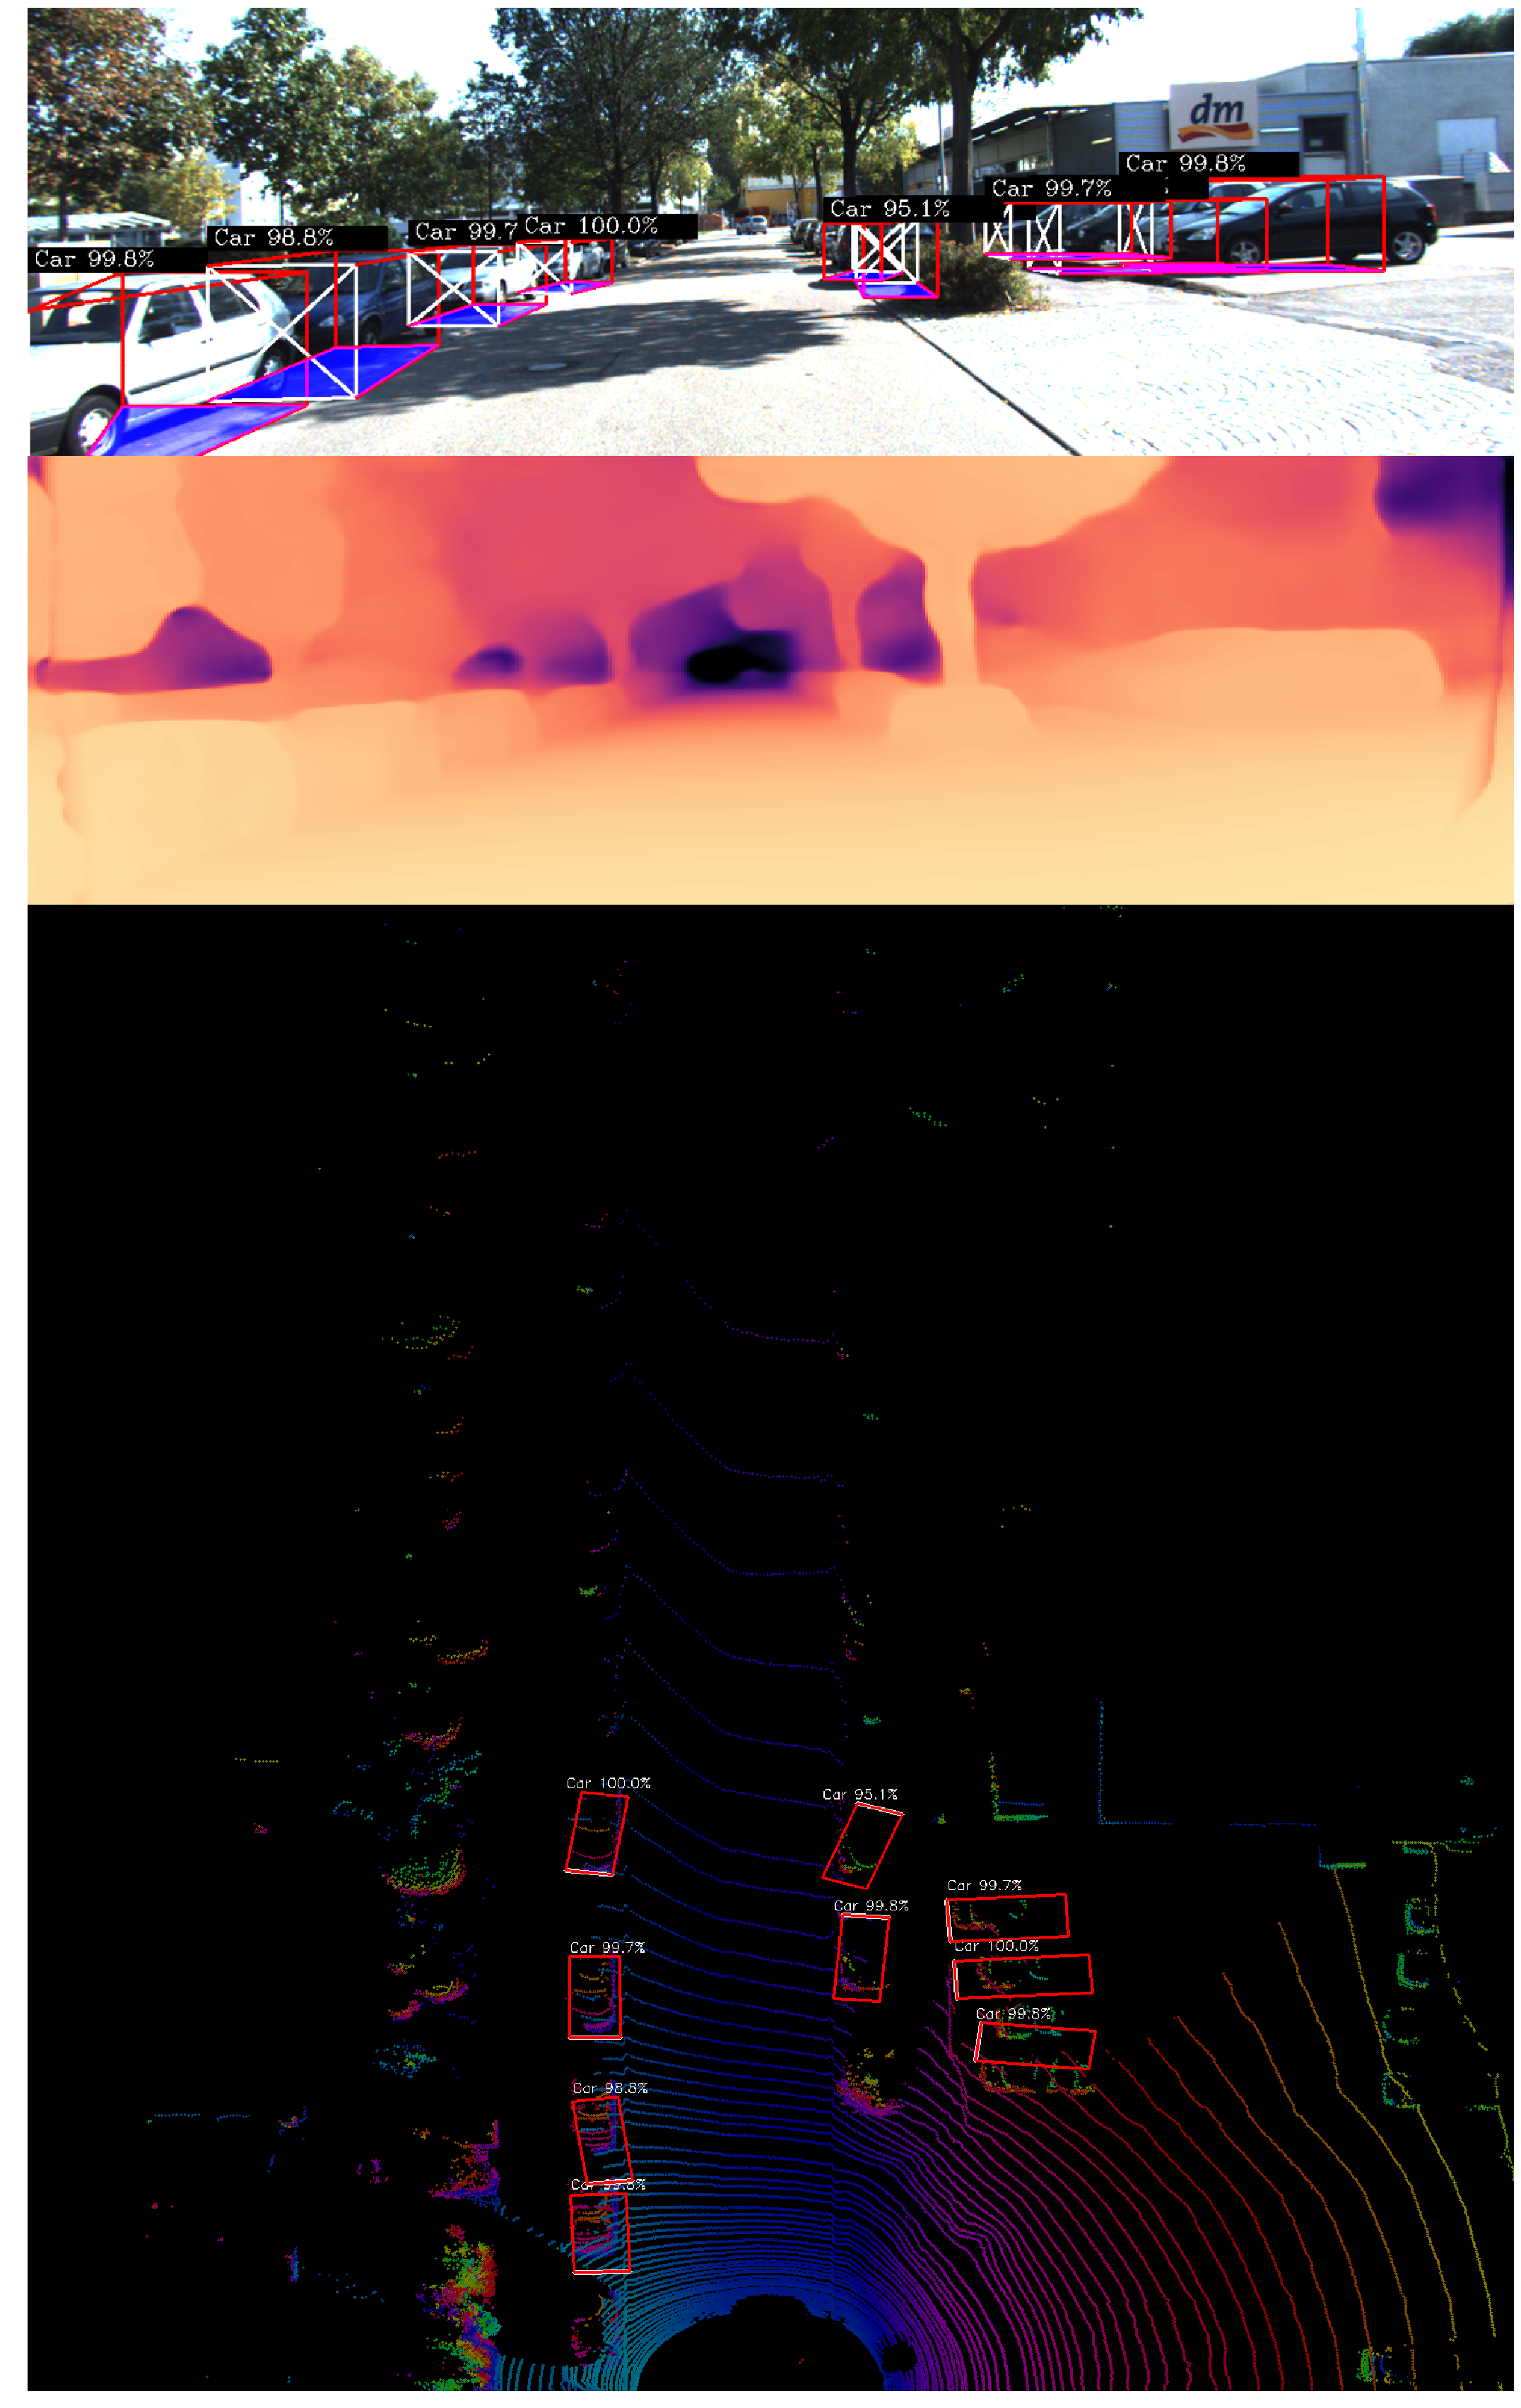

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,52))
plt.imshow(img_viz)
plt.axis('off')
plt.tight_layout()
plt.savefig('demo.png')
plt.show()